In [1]:
from od import OD
from test_data import generate_test
import datetime
from time import time
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from utils import auc, fps, TimeoutException
import os
import numpy as np
import stopit
import pandas as pd

In [2]:
n = 100
p = 32

gamma = 0.05
p_frac = 0.3
p_quant = 0.3
r = 20
# out_type = 'point'



In [7]:
def test_algo(X, outs, algo, metric):
    """
    takes in algorithm 'algo', data 'X', with outlier indices 'outs'
    returns fps and auc score, defined in the list of metrics 'metric'
    algo must have input only X
    """
    outlier_scores = algo(X)
    fps = metric[1](outlier_scores, outs)
    aucs = metric[0](outlier_scores, outs)

    return fps, aucs

def get_all_data_noise(timestamp):

    fname = './results/{}_noise_all.txt'.format(timestamp)
    df = pd.read_csv(fname, sep=',',skipinitialspace=True, index_col=False, header=0)#, names=['timestamp', 'o_type','algo', 'ta',  'p_frac', 'p_quant', 'n_runs', 'total_n_runs', 'noise_list', 'total_time', 'fp_score', 'auc_score'])

    # print(df)
    df.ta = df.ta.astype('str')
    df.n = df.n.astype('str')
    df.p = df.p.astype('str')
    df.noise = df.noise.astype('str')
    n_runs = int(df.columns[-1])


    maxes = df.max(axis=1, skipna=True, numeric_only=True)
    mins = df.min(axis=1, skipna=True, numeric_only=True)
    avg = df.mean(axis=1, skipna=True, numeric_only=True)
    df['ub'] = maxes - avg
    df['lb'] = avg - mins
    df['means'] = avg
    df = df.round(2)

    dfm=df.drop([str(x) for x in (np.arange(n_runs)+1)], axis=1)
    dfm['mean'] = avg
    dfr = dfm.pivot_table(index='algo', columns=['score','ta'], values='mean')
    dfr = dfr.round(2)
    return df, dfm, dfr


def run_noise(p_frac, p_quant, r, gamma, noise_list, ta, n, p, n_runs,algo_list,
                metric, metric_str, timeout, timestamp):
    t0 = time()

    for i in range(len(algo_list)):
        t1 = time()
        algo = algo_list[i]
        od = OD(algo)

        print('{}'.format(algo))
        fpz, aucz = get_auc_noise(p_frac, p_quant, r, noise_list, ta, n, p, n_runs,
                                    gamma,od.get_os, algo, metric, timeout,timestamp)

        label = ' ta_{}'.format(ta)
        t2 = time()-t1

        print('Algorithm {} with ta {} took {}m and {}s to run {} times'.format(algo,
                                                                    ta,
                                                                    int(t2//60),
                                                                    int(t2%60),
                                                                    len(noise_list)*n_runs))
    t3 = time()-t0
    print('Took {}m {}s to run all algorithms'.format(int(t3//60),int(t3%60)))
    return

def get_auc_noise(p_frac, p_quant, r, noise_list, ta, n, p, n_runs, gamma,algo, algo_str, metric, timeout, timestamp):
    """
    runs each algorithm with varying amounts of noise on ta given.
    """
    all_name = './results/{}_noise_all.txt'.format(timestamp)
    if not os.path.exists('results'):
        os.mkdir('results')
    if not os.path.isfile(all_name):
        with open(all_name, 'w') as f:
            info = '{}, {}, {}, {}, {}, {}, '.format('algo','ta', 'n', 'p','score', 'noise')
            info2 = ''.join(['%d, '])*n_runs%tuple(np.arange(n_runs)+1)
            f.write(info+info2[:-2]+'\n')
    fps = []
    aucs = []
    for noise in noise_list:
        Fail = False
        t0 = time()
        fp_runs=[]
        auc_runs=[]
        succeed=True

        for i in range(n_runs):
            la_err = True
            while la_err and succeed:
                try:
                    X, outs = generate_test(n, p, r, p_frac, p_quant, gamma, noise, ta=ta)
                    with stopit.ThreadingTimeout(timeout) as ctx_mgr:
                        fp, auc = test_algo(X, outs, algo, metric)
                    if ctx_mgr.state==ctx_mgr.TIMED_OUT:
                        raise TimeoutException(timeout)
                    la_err = False
                    # print('got to end of try')

                except np.linalg.LinAlgError as err:
                    if 'Singular matrix' in str(err):
                        la_err = True
                        print('redoing due to singular matrix err')
                    else:
                        # print(err)
                        print('some other linalg error')
                        raise(err)
                except TimeoutException as err:
                    # print('timeout after {}s'.format(timeout))
                    succeed = False

            if succeed:
                fp_runs.append(fp)
                auc_runs.append(auc)

            else:
                break
        t1 = time() - t0
        if Fail:
            Fail = False
            fp_row.append(np.nan)
            auc_row.append(np.nan)
            print('n={}, p={}, Failed, LinAlgError'.format(n, p))
        elif not succeed:
            print('n={}, p={}, Failed, Timeout after {}s'.format(n, p, timeout))
            fp_row.append(np.nan)
            auc_row.append(np.nan)
            with open(all_name, 'a') as f:
                fp_str = '{}, {}, {}, {}, {}, {}\n'.format(algo_str, ta, 'fps',n,p, np.nan)
                auc_str = '{}, {}, {}, {}, {}, {}\n'.format(algo_str, ta, 'auc',n,p, np.nan)
                f.write(fp_str)
                f.write(auc_str)
        else:
            fps.append(np.mean(fp_runs))
            aucs.append(np.mean(auc_runs))
            with open(all_name, 'a') as f:
                fp_str = '{}, {}, {}, {}, {}, {}, '.format(algo_str, ta, n,p,'fps',noise)
                fp_str = fp_str+''.join(['%0.3f, '])*len(fp_runs)%tuple(fp_runs)+'\n'
                auc_str = '{}, {}, {}, {}, {}, {}, '.format(algo_str, ta, n,p,'auc',noise)
                auc_str = auc_str+''.join(['%0.3f, '])*len(auc_runs)%tuple(auc_runs)+'\n'
                f.write(fp_str)
                f.write(auc_str)

            print('noise={}, runs={}, time= {}m {}s'.format(noise, n_runs, int(t1//60),int(t1%60)))
    fpz = np.array(fps)
    aucz = np.array(aucs)

    return fpz, aucz


def get_noise_plot(algo_list, ta, df, score, n_runs):

    runs_lst = np.arange(n_runs)+1
    plt.figure()
    dfa = pd.DataFrame()
    noises = []
    means=[]
    ubs=[]
    lbs=[]
    algos=[]
    # print(df)
    for ind, row in df.iterrows():
        algo = row['algo']
        ta_r = row['ta']
        score_r = row['score']
        # print(algo, ta_r, score_r)
        # print(algo in algo_list, ta_r ==str(ta), score_r==score)

        if algo in algo_list and ta_r==str(ta) and score_r==score:
            noises.append(float(row['noise']))
            means.append(row['means'])
            ubs.append(row['ub'])
            lbs.append(row['lb'])
            algos.append(algo)

    dfa['algo'] = algos
    dfa['noise'] = noises
    dfa['means'] = means
    dfa['ub'] = ubs
    dfa['lb'] = lbs
    # print(dfa)

    for algo in algo_list:
        algo_df = dfa[dfa['algo']==algo]
#         print(algo_df)
        if algo == 'Ridge':
            lab = 'FRR'
        else:
            lab = algo
        plt.errorbar(algo_df.noise, algo_df.means, yerr=(algo_df.lb, algo_df.ub), label=lab, capsize=5, capthick=1)
    plt.title('D{}'.format(ta))
    plt.legend()
    if score == 'auc':
        plt.axis([0,1,0.4,1.05])
    else:
        #ie score is fps
        plt.axis([0,1,0,1.05])
    plt.xlabel('noise')
    plt.ylabel(score)
    plt.savefig('./images/comp_noise_ta{}_{}.png'.format(ta, score))
    plt.show()


def run_noise_experiment_3(timestamp):
    """
    to run experiment 3 varying noise as in the paper.
    """
    algo_lst = ['VAR', 'FRO', 'FRL', 'FRR', 'OCSVM', 'GMM', 'DBSCAN', 'IF','AE', 'VAE', 'LSTM', 'GRU', 'OP', 'GOP']
    #set parameters
    #for data
    r = 20 # rank of lower d subspace for D1 and D2.
    p_frac = 0.3 #fraction of features in outliers that are outlying.
    p_quant = 0.3 # extend to which those features are changed.
    gamma = 0.05 #fraction that are outliers.
    noise=.1
    n = 100
    p = 32
    #for expt
    timeout = 900 #experiment will time out in this num seconds.
    n_runs = 10
    noise_list=np.arange(0,1.01,0.05)



    ## for Testing
    algo_lst=['VAR', 'FRO', 'FRL', 'FRR', 'OCSVM']
    n_runs=2
    ta_lst = [1, 2]
    ## end of testing section

    metric_lst = [auc, fps]
    metric_str_lst = ['AUC', 'FPs']
    print(timestamp)
    for ta in ta_lst:

        run_noise(p_frac, p_quant, r, gamma, noise_list, ta, n, p, n_runs, algo_lst,
                         metric_lst, metric_str_lst, timeout, timestamp)
    df, dfm, dfr = get_all_data_noise(timestamp) #reads results from file.
    print(dfr)
    algo_list = ['FRR', 'VAR', 'OCSVM']
    ta=1
    score = 'auc'
    get_noise_plot(algo_list, ta, df, score, n_runs)



2021-07-16_12-03-52
2021-07-16_12-03-52
VAR
noise=0.0, runs=2, time= 0m 0s
noise=0.05, runs=2, time= 0m 0s
noise=0.1, runs=2, time= 0m 0s
noise=0.15000000000000002, runs=2, time= 0m 0s
noise=0.2, runs=2, time= 0m 0s
noise=0.25, runs=2, time= 0m 0s
noise=0.30000000000000004, runs=2, time= 0m 0s
noise=0.35000000000000003, runs=2, time= 0m 0s
noise=0.4, runs=2, time= 0m 0s
noise=0.45, runs=2, time= 0m 0s
noise=0.5, runs=2, time= 0m 0s
noise=0.55, runs=2, time= 0m 0s
noise=0.6000000000000001, runs=2, time= 0m 0s
noise=0.65, runs=2, time= 0m 0s
noise=0.7000000000000001, runs=2, time= 0m 0s
noise=0.75, runs=2, time= 0m 0s
noise=0.8, runs=2, time= 0m 0s
noise=0.8500000000000001, runs=2, time= 0m 0s
noise=0.9, runs=2, time= 0m 0s
noise=0.9500000000000001, runs=2, time= 0m 0s
noise=1.0, runs=2, time= 0m 0s
Algorithm VAR with ta 1 took 0m and 2s to run 42 times
FRO
noise=0.0, runs=2, time= 0m 0s
noise=0.05, runs=2, time= 0m 0s
noise=0.1, runs=2, time= 0m 0s
noise=0.15000000000000002, runs=2, tim

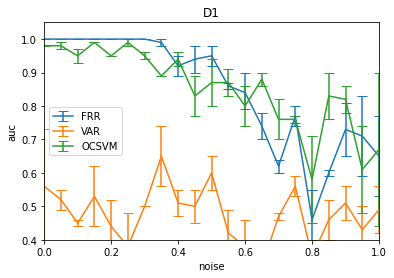

In [8]:
timestamp = datetime.datetime.fromtimestamp(time())
timestamp = timestamp.strftime('%Y-%m-%d_%H-%M-%S')
print(timestamp)
run_noise_experiment_3(timestamp)